In [1]:
!pip install keras-tuner

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D

from keras.utils import plot_model
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras import layers

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [3]:
%load_ext autotime
RANDOM_STATE = 42

In [4]:
seed = 7
np.random.seed(seed)

time: 82.9 ms


In [5]:
MEMORY_LIMIT = 4500
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)

time: 129 ms


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 61.5 ms


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

time: 563 ms


In [8]:
tf.test.is_built_with_cuda()

True

time: 2.1 ms


In [9]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

time: 110 ms


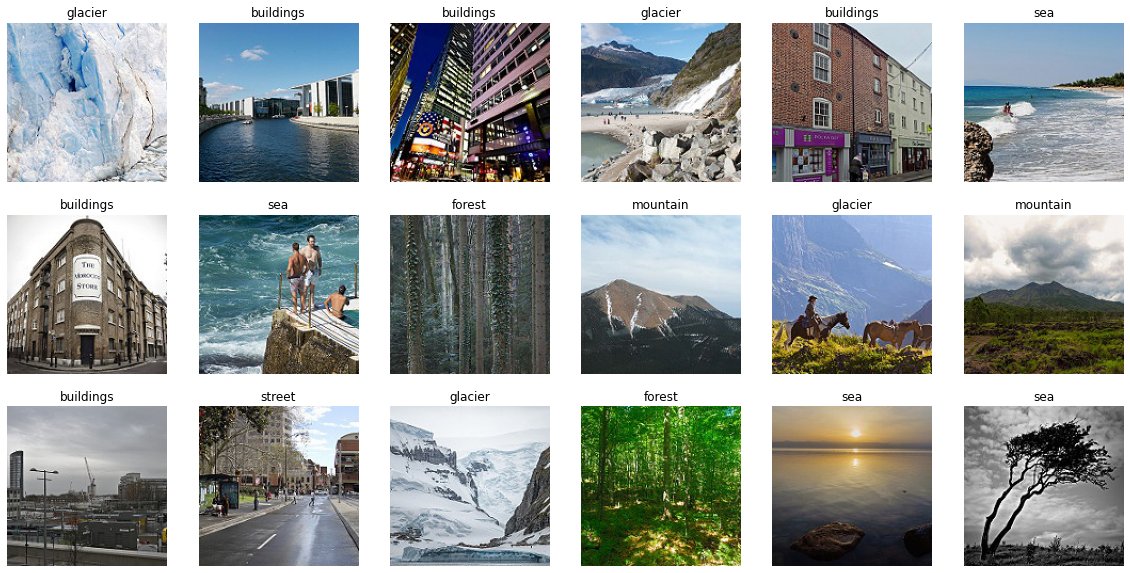

time: 962 ms


In [10]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/',target_class=class_name)

In [11]:
train_dir = "/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/"
test_dir = "/home/anjir29/Desktop/America/data/archive/seg_test/seg_test/"
val_dir ="/home/anjir29/Desktop/America/data/archive/seg_val/seg_test/"

time: 481 µs


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
time: 709 ms


In [13]:
LOG_DIR = f"{int(time.time())}"

time: 549 µs


In [14]:
def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',input_shape=(32, 32,3),activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu', 'tanh', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, activation=hp.Choice('activation_1',values=['relu', 'elu', 'gelu', 'selu'],default='relu'), padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    #####################################Block 2#################################         
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 3#################################            
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 4################################
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 5#################################
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ############################################################################
    model.add(Dropout(hp.Choice('dp_size_6', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dropout(hp.Choice('dp_size_7', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Dense(units=6, activation="softmax"))
 ##############################################################################           
    
    opt = Adam(lr=hp.Choice('learning_rate', values=[0.1,0.01, 0.001, 0.0001],default=0.01))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                  optimizer=opt,
                                                  metrics=['accuracy'])
    return model

time: 116 ms


In [15]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='RS_Vgg16_Intel')

time: 501 ms


In [16]:
tuner.search_space_summary()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)

Trial 90 Complete [00h 03m 39s]
val_accuracy: 0.1666666716337204

Best val_accuracy So Far: 0.8208333253860474
Total elapsed time: 02h 06m 39s
INFO:tensorflow:Oracle triggered exit
time: 2h 6min 39s


In [17]:
tuner.results_summary()

with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Results summary
Results in 1624346855/RS_Vgg16_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_size_1: 32
activation_2: elu
dp_size_1: 0.0
activation_1: selu
layer_size_2: 128
dp_size_2: 0.1
layer_size_3: 256
activation_3: elu
dp_size_3: 0.2
layer_size_4: 32
activation_4: elu
dp_size_4: 0.4
layer_size_5: 256
activation_5: gelu
dp_size_5: 0.3
dp_size_6: 0.4
dense_size_1: 256
activation_dense: selu
wd_size_1: 0.001
dense_size_2: 64
dp_size_7: 0.3
learning_rate: 0.0001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 17a3622c487d9e7f7cccabb45fcebc68
Score: 0.8208333253860474
Trial summary
Hyperparameters:
layer_size_1: 32
activation_2: tanh
dp_size_1: 0.2
activation_1: selu
layer_size_2: 128
dp_size_2: 0.1
layer_size_3: 256
activation_3: relu
dp_size_3: 0.1
layer_size_4: 64
activation_4: elu
dp_size_4: 0.1
layer_size_5: 32
activation_5: elu
dp_size_5: 0.0
dp_size_6: 0.3
dense_size_1: 

In [18]:
new_model = tuner.get_best_hyperparameters()[0]

time: 90.4 ms


In [19]:
model = tuner.hypermodel.build(new_model)

time: 426 ms


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

In [21]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 14s 30ms/step - loss: 1.9088 - accuracy: 0.3084 - val_loss: 1.3657 - val_accuracy: 0.5775
Epoch 2/100
439/439 [==============================] - 13s 29ms/step - loss: 1.3909 - accuracy: 0.5735 - val_loss: 1.1741 - val_accuracy: 0.6800
Epoch 3/100
439/439 [==============================] - 13s 29ms/step - loss: 1.2456 - accuracy: 0.6343 - val_loss: 1.2884 - val_accuracy: 0.6658
Epoch 4/100
439/439 [==============================] - 12s 28ms/step - loss: 1.1439 - accuracy: 0.6766 - val_loss: 1.0412 - val_accuracy: 0.7250
Epoch 5/100
439/439 [==============================] - 13s 29ms/step - loss: 1.0584 - accuracy: 0.7109 - val_loss: 0.9855 - val_accuracy: 0.7367
Epoch 6/100
439/439 [==============================] - 13s 29ms/step - loss: 0.9918 - accuracy: 0.7323 - val_loss: 0.9898 - val_accuracy: 0.7337
Epoch 7/100
439/439 [==============================] - 13s 30ms/step - loss: 0.9486 - accuracy: 0.7467 - val_loss: 1.0216 - val_ac

In [23]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 0s 21ms/step - loss: 1.2686 - accuracy: 0.6875
time: 100 ms
